## This tutorial will explain the feature extraction pipeline for heart rate variabilities in details
In this notebook I'll show you an example of using [hrv-analysis](https://github.com/Aura-healthcare/hrvanalysis) package to extract HRV features. If you have ECG as the inputs, please visit these website for processing ECG [Heart Rate Analysis Toolkit](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/quickstart.html#getting-heart-rate-over-time) For more information about the cardiac sensing, please visit [Physionet](https://archive.physionet.org/tutorials/) 

Since sleep PSG data is annotated every 30 seconds, in this tutorial we will extract HRV features from each sleep epoch. According to the guidence of physiological pratice, different HRV features require different minimum recording window lengths (e.g. Poincaré plot requires not less than 5 minutes). However, we found that models using HRV features extracted from the sliding window of five-minute length perform worse than the ones using window length of 30-second. 

This tutorial is organised in the following way:
1. [Loading Data](#data_loading)
2. [Visualisation](#visualisation)
3. [RR Interval Data Cleaning](#data_clearning)
4. [Feature Extraction](#feature_extraction)
    1. [Time Domain Feature Extraction](#time_domain_feature)
    2. [Frequency Domain Feature Extraction](#frequency_domain_feature)
    3. [Poincaré Feature](#poincaré_feature)
    4. [Non-linear Domain Feature](#non_linear_domain_feature)
    5. [Geometrical Time Domain Feature](#geometrical_time_domain_feature)
    

At the start of the juputer notebook, we will import the relavent python packages. To install hrv-analysis package please do `pip install hrv-analysis`

In [1]:
%matplotlib inline
%matplotlib notebook
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import hrvanalysis as hrvana
import numpy as np

**hrv_file** variable is the path of RR-interval file you stored.  This R point file was exported from Compumedics Profusion software and downloaded from [MESA](https://sleepdata.org/datasets/mesa) website

In [25]:
hrv_file = r"\Dataset\MESA\annotations-rpoints\mesa-sleep-0001-rpoint.csv" # This is the R-point data you downloaded from MESA

<a id="data_loading"></a>
## Loading Data
Let's load the data to pandas DataFrame.

In [34]:
hrv_df = pd.read_csv(hrv_file)
hrv_df.head() # show the first 5 rows of records

,epoch,RPoint,Start,End,STLevel1,STSlope1,STLevel2,STSlope2,Manual,Type,Class,PPoint,PStart,PEnd,TPoint,TStart,TEnd,TemplateID,seconds,stage
0,1,149,144,155,220,-1292,9866,0,0,1,NaN,NaN,NaN,NaN,215,NaN,NaN,0,0.582031,0
1,1,332,325,346,214,1998,346,0,0,1,NaN,NaN,NaN,NaN,393,NaN,NaN,0,1.296875,0
2,1,533,502,546,-931,1783,546,0,0,1,NaN,NaN,NaN,NaN,595,NaN,NaN,0,2.082031,0
3,1,733,723,746,24,1077,746,0,0,1,NaN,NaN,NaN,NaN,793,NaN,NaN,0,2.863281,0
4,1,930,920,937,216,-865,937,0,0,1,NaN,NaN,NaN,NaN,990,NaN,NaN,0,3.632812,0


The **seconds** column contains the time difference in seconds from each R peak to the **start** of the recording. we will calculate the RR intervals based on the difference between each R points.

In [36]:
hrv_df = hrv_df[hrv_df['TPoint'] > 0] # Let's filter the data by excluding any invalid values in the file
hrv_df['RR Intervals'] = hrv_df['seconds'].diff().values * 1000 # convert seconds to milliseconds
hrv_df.loc[0, 'RR Intervals']=hrv_df.loc[0]['seconds'] * 1000

In [37]:
hrv_df.head()

,epoch,RPoint,Start,End,STLevel1,STSlope1,STLevel2,STSlope2,Manual,Type,...,PPoint,PStart,PEnd,TPoint,TStart,TEnd,TemplateID,seconds,stage,RR Intervals
0,1,149,144,155,220,-1292,9866,0,0,1,...,NaN,NaN,NaN,215,NaN,NaN,0,0.582031,0,582.03125
1,1,332,325,346,214,1998,346,0,0,1,...,NaN,NaN,NaN,393,NaN,NaN,0,1.296875,0,714.84375
2,1,533,502,546,-931,1783,546,0,0,1,...,NaN,NaN,NaN,595,NaN,NaN,0,2.082031,0,785.15625
3,1,733,723,746,24,1077,746,0,0,1,...,NaN,NaN,NaN,793,NaN,NaN,0,2.863281,0,781.25000
4,1,930,920,937,216,-865,937,0,0,1,...,NaN,NaN,NaN,990,NaN,NaN,0,3.632812,0,769.53125


In [38]:
hrv_df.loc[hrv_df.stage>4, "stage"]=4 # make sure sleep stages are between 0-4

<a id="visualisation"></a>
## Visualisation 

Let's have a look of sleep stages and raw RR intervals

<IPython.core.display.Javascript object>


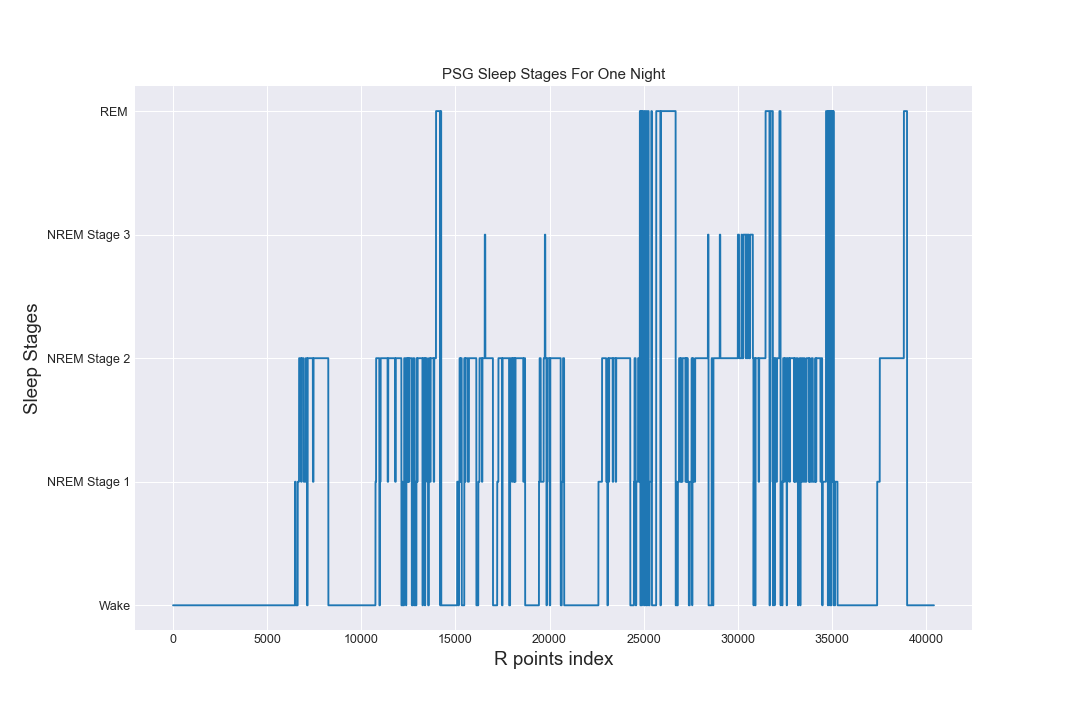

In [39]:
style.use("seaborn-darkgrid")
fig1, ax1 = plt.subplots(figsize=(12, 8))
ax1.set_title("PSG Sleep Stages For One Night")
ax1.set_ylabel("Sleep Stages", fontsize=15)
ax1.set_xlabel("R points index", fontsize=15)
ax1.set_yticks(np.arange(5))
ax1.set_yticklabels(["Wake","NREM Stage 1",  "NREM Stage 2", "NREM Stage 3", "REM "])
ax1.plot(hrv_df['stage'].values)
plt.show()


<IPython.core.display.Javascript object>


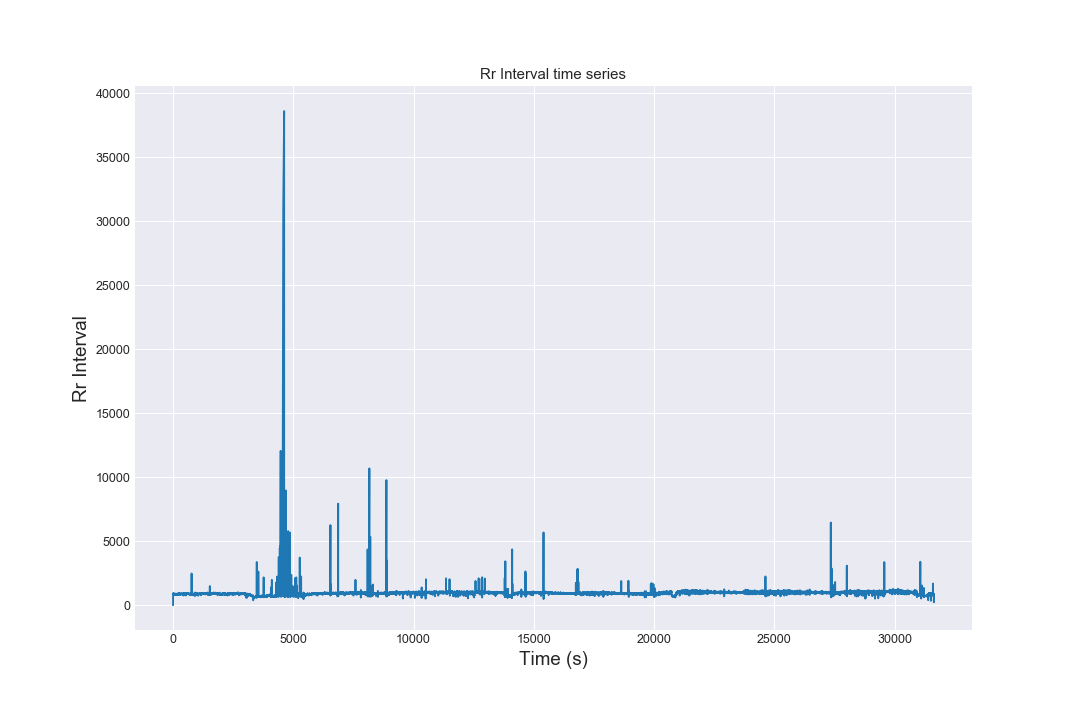

In [8]:
hrvana.plot_timeseries(hrv_df["RR Intervals"].values.tolist())

<a id="cleaning"></a>
## RR Interval Data Cleaning
To cleaning HRV data, we do the following steps:
1. Removing outliters, we accept the valid RR interval between 300ms to 2000ms.
2. Interpolating removed Nan with forward linear interpolation (values calculated using future RR intervals. We ignored the index and treat the values as equally spaced.  more details please see: [Pandas Interpolation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) [HRV-Analysis Interpolation](https://github.com/Aura-healthcare/hrvanalysis/blob/master/hrvanalysis/preprocessing.py))
3. Using method proposed by Malik M et al. [Heart Rate Variability](https://doi.org/10.1111/j.1542-474X.1996.tb00275.x) to remove ectopic beats
4. Interpolating removed Nan with forward linear interpolation 


In [40]:
clean_rri = hrv_df['RR Intervals'].values
clean_rri = hrvana.remove_outliers(rr_intervals=clean_rri, low_rri=300, high_rri=2000)
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")
clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik")
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear") # default is linear

218 outlier(s) have been deleted.
The outlier(s) value(s) are : [250.0, 296.875, 261.71900000008463, 242.18800000016927, 222.65599999991537, 281.25, 8207.030999999915, 5132.813000000169, 2203.125, 25617.18699999983, 22882.81200000074, 51914.06200000074, 12632.81299999926, 4910.156000000825, 4054.6869999998307, 4972.655999999915, 5054.68799999926, 24996.094000000085, 14804.68799999926, 2371.0940000000846, 3902.3430000006556, 80726.56300000017, 5367.186999999831, 5613.280999999915, 4148.436999999831, 9894.530999999915, 8386.718000000656, 28371.094000000085, 7710.938000000169, 3394.531000000825, 3476.5630000001693, 7765.625, 3531.25, 3484.375, 9613.281000000825, 2386.718999999175, 5023.438000000169, 8996.093000000656, 4320.313000000169, 7695.313000000169, 14210.93699999983, 2585.9380000001693, 2574.2190000000846, 4304.688000000169, 24964.844000000085, 4046.875, 5019.530999999915, 5808.592999999746, 29187.5, 14605.469000000085, 3300.7809999999154, 3324.2190000000846, 2542.967999999746, 585

Now let's visualise the processed NN intervals

<IPython.core.display.Javascript object>


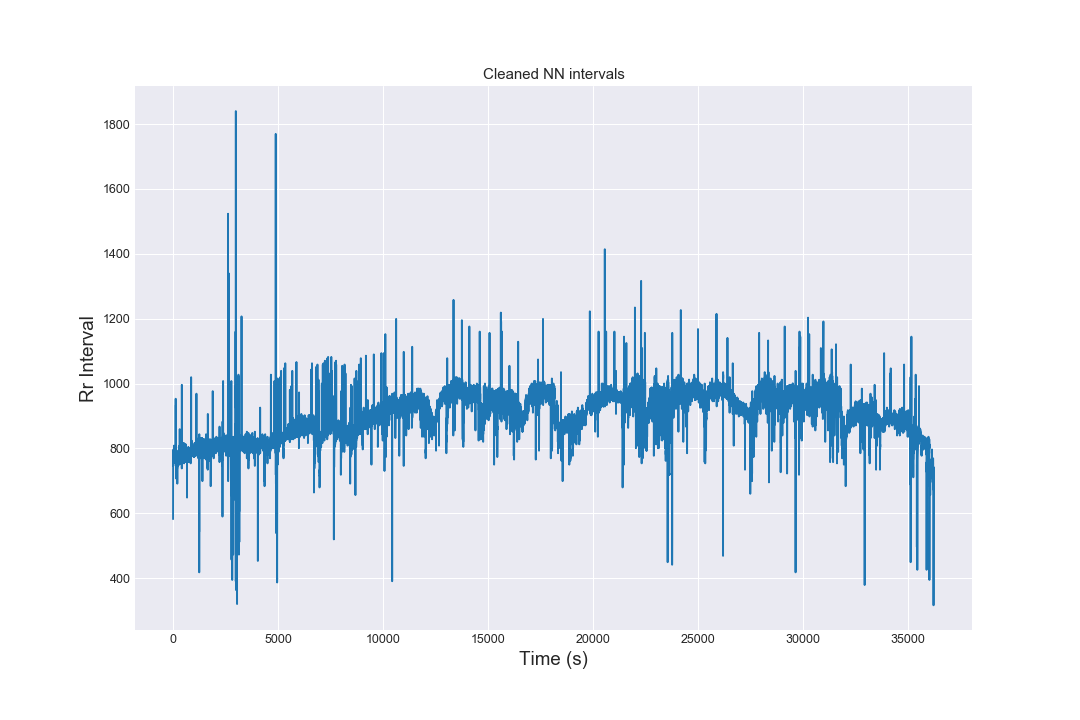

Text(0.5, 1.0, 'Cleaned NN intervals')

In [82]:
hrvana.plot_timeseries(clean_rri)
plt.title("Cleaned NN intervals")


In [43]:
hrv_df["RR Intervals"] = clean_rri # assign the process RR intervals to the dataframe
hrv_df["RR Intervals"].isna().any()

False

<a id="feature_extraction"></a>
## HRV Feature Extraction
The following code will show you how to extract HRV features from NN intervals in a sleep epoch (one sleep epoch contains 30 seconds of data)
Let's extract the NN intervals of the first sleep epoch

In [44]:
rr_epoch = hrv_df[hrv_df['epoch'] == 1]['RR Intervals'].values

In [45]:
rr_epoch

array([582.03125, 683.59375, 785.15625, 781.25   , 769.53125, 792.96875,
       789.0625 , 777.34375, 785.15625, 777.34375, 792.96875, 777.34375,
       777.34375, 769.53125, 757.8125 , 746.09375, 781.25   , 773.4375 ,
       777.34375, 769.53125, 773.4375 , 789.0625 , 773.4375 , 781.25   ,
       769.53125, 792.96875, 792.96875, 789.0625 , 785.15625, 781.25   ,
       769.53125, 761.71875, 796.875  , 789.0625 , 781.25   , 761.71875,
       781.25   , 769.53125])

<a id="time_domain_feature"></a>
### Extract Time Domain Features
- **mean_nni**: The mean of NN-intervals.
- **sdnn** : The standard deviation of the time interval between successive normal heart beats (i.e. the NN-intervals).
- **sdsd**: The standard deviation of differences between adjacent NN-intervals
- **rmssd**: The square root of the mean of the sum of the squares of differences between adjacent NN-intervals. Reflects high frequency (fast or parasympathetic) influences on HRV (*i.e.*, those influencing larger changes from one beat to the next).
- **median_nni**: Median Absolute values of the successive differences between the NN-intervals.
- **nni_50**: Number of interval differences of successive NN-intervals greater than 50 ms.
- **pnni_50**: The proportion derived by dividing nni_50 (The number of interval differences of successive NN-intervals greater than 50 ms) by the total number of NN-intervals. (%)
- **nni_20**: Number of interval differences of successive NN-intervals greater than 20 ms.
- **pnni_20**: The proportion derived by dividing nni_20 (The number of interval differences of successive NN-intervals greater than 20 ms) by the total number of NN-intervals. (%)
- **range_nni**: Difference between the maximum and minimum NN_interval.
- **cvsd**: Coefficient of variation of successive differences equal to the rmssd divided by mean_nni.
- **cvnni**: Coefficient of variation equal to the ratio of sdnn divided by mean_nni.
- **mean_hr**: The mean Heart Rate.
- **max_hr**: Max heart rate.
- **min_hr**: Min heart rate.
- **std_hr**: Standard deviation of heart rate.

Note: we measure NN Intervals in ms

In [53]:
hrvana.get_time_domain_features(rr_epoch)

{'mean_nni': 897.276976146393,
 'sdnn': 19.122753343422136,
 'sdsd': 17.76712832932793,
 'nni_50': 1,
 'pnni_50': 2.9411764705882355,
 'nni_20': 8,
 'pnni_20': 23.529411764705884,
 'rmssd': 17.84719721824771,
 'median_nni': 898.4375,
 'range_nni': 79.16354265157781,
 'cvsd': 0.019890399166261338,
 'cvnni': 0.02131198487400195,
 'mean_hr': 66.89849184863968,
 'max_hr': 70.13698630136986,
 'min_hr': 64.19636949390902,
 'std_hr': 1.4059100819543506}

<a id="frequency_domain_feature"></a>
### Extract Frequence Domain Features
- **total_power** : Total spectral power of all NN intervals (LF + HF + VLF)
- **vlf** : Variance ( = power ) in HRV in the Very low Frequency (.003 to .04 Hz by default). Reflect an intrinsic rhythm produced by the heart which is modulated primarily by sympathetic activity.
- **lf** : Variance ( = power ) in HRV in the low Frequency (.04 to .15 Hz). Reflects a mixture of sympathetic and parasympathetic activity, but in long-term recordings, it reflects sympathetic activity and can be reduced by the beta-adrenergic antagonist propanolol.
- **hf**: Variance ( = power ) in HRV in the High Frequency (.15 to .40 Hz by default). Reflects fast changes in beat-to-beat variability due to parasympathetic (vagal) activity. Sometimes called the respiratory band because it corresponds to HRV changes related to the respiratory cycle and can be increased by slow, deep breathing (about 6 or 7 breaths per minute) and decreased by anticholinergic drugs or vagal blockade.
- **lf_hf_ratio** : lf/hf ratio is sometimes used by some investigators as a quantitative mirror of the sympatho/vagal balance.
- **lfnu** : Normalized lf power. Units: normalized units = $LF/(total power−VLF)×100$
- **hfnu** : Normalized hf power. Units: normalized units = $HF/(total power−VLF)×100$

Note: Spectral power is measured in $msec^2$ 

c:\users\admin\anaconda3\envs\tf2\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


<IPython.core.display.Javascript object>


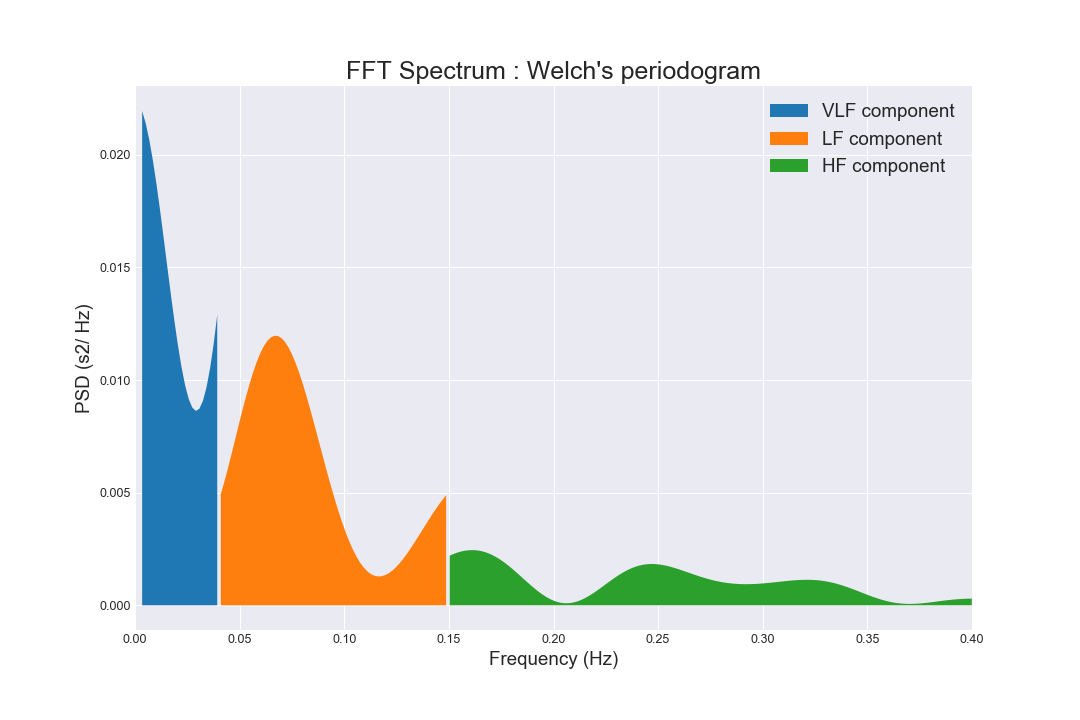

<IPython.core.display.Javascript object>


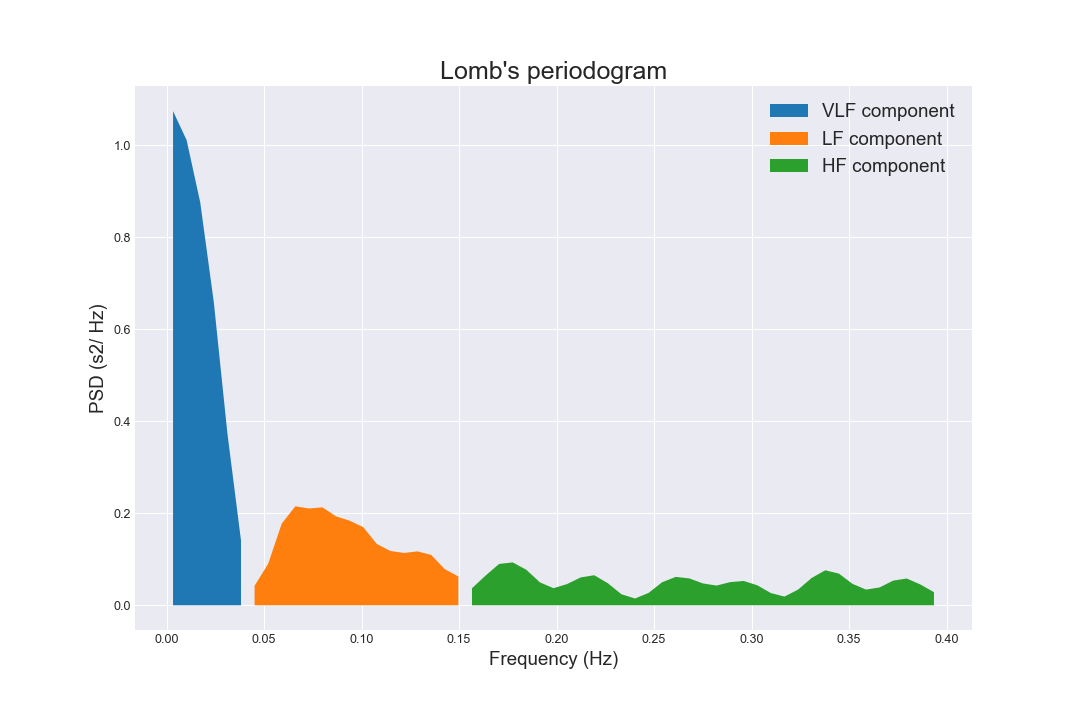

In [48]:
hrvana.plot_psd(rr_epoch)
hrvana.plot_psd(rr_epoch, method="lomb")

In [49]:
hrvana.get_frequency_domain_features(rr_epoch)

c:\users\admin\anaconda3\envs\tf2\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


{'lf': 40.90000696657587,
 'hf': 36.88707675165494,
 'lf_hf_ratio': 1.1087895970162747,
 'lfnu': 52.5794322290427,
 'hfnu': 47.42056777095731,
 'total_power': 88.36695884884966,
 'vlf': 10.579875130618854}

<a id="poincaré_feature"></a>
### Extract Features from Poincaré plot (Non-linear Domain)
Note: Known practise is to use this function on short term recordings, from 5 minutes window.

<IPython.core.display.Javascript object>


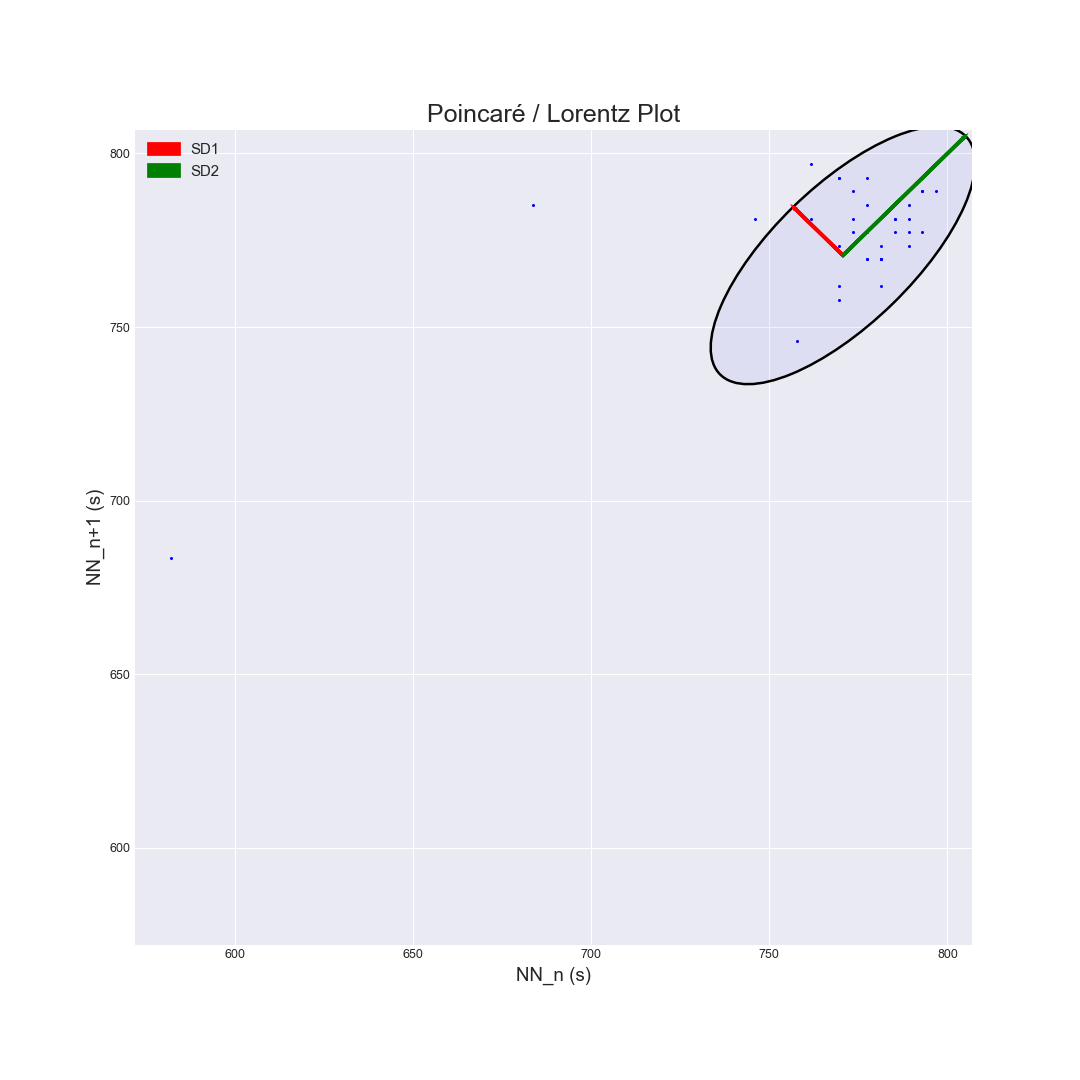

In [50]:
hrvana.plot_poincare(rr_epoch)

In [51]:
hrvana.get_poincare_plot_features(rr_epoch)

{'sd1': 19.223540302898627,
 'sd2': 48.12328372513283,
 'ratio_sd2_sd1': 2.5033517742762785}

<a id="non_linear_domain_feature"></a>
### Extract Non-linear Domain Features 
These features includes CVI (cardiovagal index), CSI (cardiosympathetic index) and Modified CSI(is an alternative measure in research of [seizure detection](https://doi.org/10.1109/embc.2014.6944639)). 


In [52]:
hrvana.get_csi_cvi_features(rr_epoch)

{'csi': 2.5033517742762785,
 'cvi': 4.170308609247983,
 'Modified_csi': 481.87803078924816}

<a id="geometrical_time_domain_feature"></a>
### Extract Geometrical Time Domain Features 
The known practise is to use these features on recordings from 20 minutes to 24 Hours window. We discarded the triangular interpolation of NN-interval histogram (TINN)

In [53]:
hrvana.get_geometrical_features(rr_epoch)

{'triangular_index': 4.222222222222222, 'tinn': None}

The next step is to loop through all sleep epochs to extract HRV features for each sleep epoch

In [54]:
hrv_win = 0 # 0 means we use one sleep epoch as the window length (every 30s)

feature_list = []
# go through all sleep epochs and extract HRV features from them
for index, hrv_epoch_idx in enumerate(hrv_df['epoch'].unique()):
    gt_label = hrv_df[hrv_df['epoch'] == hrv_epoch_idx]["stage"].values[0]  # in MESA r-points files, the stage is annotated by the sleep experts
    if hrv_win != 0:  # if you want get the features from a 5 min window, please set hrv_win = 10, as per sleep epoch is 30s
        offset = int(np.floor(hrv_win/2))
        tmp_hr_df = hrv_df[hr_df['epoch'].isin(np.arange(hrv_epoch_idx-offset, hrv_epoch_idx+offset))]
    else:
        tmp_hr_df = hrv_df[hrv_df['epoch'] == hrv_epoch_idx]
    try:  # check to see if the first time stamp is empty
        start_sec = float(tmp_hr_df['seconds'].head(1) * 1.0)
    except Exception as ee:
        print("Exception %s, source dataset: %s" % (ee, tmp_hr_df['seconds'].head(1)))
    # calculate the HRV features for each epoch
    rr_epoch = tmp_hr_df['RR Intervals'].values
    all_hr_features = {}
    try:
        all_hr_features.update(hrvana.get_time_domain_features(rr_epoch))
    except Exception as ee:
        print("processed time domain features with error message: {}".format(str(ee)))
    try:
        all_hr_features.update(hrvana.get_frequency_domain_features(rr_epoch))
    except Exception as ee:
        print("processed frequency domain features with error message: {}".format(str(ee)))
    try:
        all_hr_features.update(hrvana.get_poincare_plot_features(rr_epoch))
    except Exception as ee:
        print("processed poincare features: {} with error message".format(str(ee)))
    try:
        all_hr_features.update(hrvana.get_csi_cvi_features(rr_epoch))
    except Exception as ee:        
        print("processed csi cvi domain features: {} with error message".format(str(ee)))
    try:
        all_hr_features.update(hrvana.get_geometrical_features(rr_epoch))
    except Exception as ee:
        print("processed geometrical features: {} with error message".format(str(ee)))

    all_hr_features.update({'stages': gt_label                            
                            , 'epoch': hrv_epoch_idx
                            #, 'index': index
                            })
    feature_list.append(all_hr_features)
hrv_feature_df = pd.DataFrame(feature_list)


Now you have the **hrv_feature_df**